In [1]:
#Imports
import numpy as np
from itertools import product
import math
from scipy.sparse import kron, csr_matrix
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import qutip.piqs as piqs
from qutip import mesolve, expect
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csc_matrix,csr_matrix,lil_matrix
import time
from qutip import *

In [2]:
# Number of qutrits
N=3

'''
# Initial state parameters |theta,phi>
theta = np.pi
phi = np.pi/4
'''

# Lindblad parameters
gamma20=0             #Decay rate between 2->0
k02=0                 #Pumping rate between 0->2
gamma_phi02=0         #Dephasing rate between 0 and 2 states
gamma_col20=0        #Collective Decay rate between 2->0
k_col02=0.5             #Collective Pumping rate between 0->2
gamma_phi_col02=0     #Collective Dephasing rate between 0 and 2 states

gamma21=0.3             #Decay rate between 2->1
k12=0                #Pumping rate between 1->2
gamma_phi12=0         #Dephasing rate between 1 and 2 states
gamma_col21=0         #Collective Decay rate between 2->1
k_col12=0             #Collective Pumping rate between 1->2
gamma_phi_col12=0     #Collective Dephasing rate between 1 and 2 states


gamma10=0             #Decay rate between 1->0 
k01=0                 #Pumping rate between 0->1
gamma_phi01=0         #Dephasing rate between 0 and 1 states
gamma_col10=0.8         #Collective Decay rate between 1->0 
k_col01=0             #Collective Pumping rate between 0->1
gamma_phi_col01=0     #Collective Dephasing rate between 0 and 1 states

In [3]:
#Creating the number basis class
class SymmetricLiouvilleQubitNumberBasis:
    def __init__(self, N):
        self.N = N
        self.q = 3
        self.d = self.q ** 2
        self.basis = self._generate_basis()
        self.index_map = {tuple(state): i for i, state in enumerate(self.basis)}

    def _generate_basis(self):
        def compositions(n, k):
            if k == 1:
                yield (n,)
            else:
                for i in range(n + 1):
                    for rest in compositions(n - i, k - 1):
                        yield (i,) + rest

        basis = list(compositions(self.N, self.d))
        basis.reverse()  
        return basis

    def dim(self):
        return len(self.basis)

    def get_index(self, n_tuple):
        return self.index_map.get(tuple(n_tuple), -1)

    def show_basis(self, compact=True):
        for i, state in enumerate(self.basis):
            if compact:
                print(f"{i}: {state}")
            else:
                mat = np.array(state).reshape(self.q, self.q)
                print(f"{i}:\n{mat}\n")

Numberbasis=SymmetricLiouvilleQubitNumberBasis(N)

In [4]:
#Defining the collective operators
def collective_J_right(x,y):
    L= lil_matrix((Numberbasis.dim(),Numberbasis.dim()))

    for idx,n in enumerate(Numberbasis.basis):  
        nij=np.array(n).reshape(3,3)

        for k in range(3):
            n_copy = nij.copy()
            n_copy[x,k] += 1
            n_copy[y,k] -= 1
           
            new_index = Numberbasis.get_index(n_copy.flatten())
           
            if new_index != -1:
                L[idx,new_index]+=(nij[x,k]+1) if nij[y,k] > 0 else 0
    return L

def collective_J_left(x,y):
    M= lil_matrix((Numberbasis.dim(),Numberbasis.dim()))
    for idx,n in enumerate(Numberbasis.basis):  
        nij=np.array(n).reshape(3,3)

        for k in range(3):
            n_copy = nij.copy()
            n_copy[k,x] -= 1
            n_copy[k,y] += 1
           
            new_index = Numberbasis.get_index(n_copy.flatten())
           
            if new_index != -1:
                M[idx,new_index]+=(nij[k,y]+1) if nij[k,x] > 0 else 0

    return M

J_right22=collective_J_right(2,2)
J_right11=collective_J_right(1,1)
J_right00=collective_J_right(0,0)
J_right20=collective_J_right(2,0)
J_right02=collective_J_right(0,2)
J_right21=collective_J_right(2,1)
J_right12=collective_J_right(1,2)
J_right10=collective_J_right(1,0)
J_right01=collective_J_right(0,1)  

J_left22=collective_J_left(2,2)
J_left11=collective_J_left(1,1)
J_left00=collective_J_left(0,0)
J_left20=collective_J_left(2,0)
J_left02=collective_J_left(0,2)
J_left21=collective_J_left(2,1)
J_left12=collective_J_left(1,2)
J_left10=collective_J_left(1,0)
J_left01=collective_J_left(0,1)

In [5]:
P_values0=np.zeros(Numberbasis.dim())
#P_values0[0]=1  #Ground state
P_values0[-1]=1 #Excited state

P_values=P_values0.copy()

#Constructing the Entire Liouvillian

Hamiltonian=lil_matrix((Numberbasis.dim(),Numberbasis.dim()))              #Hamiltonian


#Defining the rate of change of P values
dP_dt=lil_matrix((Numberbasis.dim(),Numberbasis.dim()))
for idx, n in enumerate(Numberbasis.basis):
    nij=np.array(n).reshape(3,3)


    #For decay 2->0
    if gamma20!=0:
        nij_copy=nij.copy()
        nij_copy[2,2]+=1
        nij_copy[0,0]-=1

        i=Numberbasis.get_index(nij_copy.flatten())
   
        dP_dt[idx,idx]+=-gamma20/2*((2*nij[2,2]+nij[2,0]+nij[0,2]+nij[2,1]+nij[1,2]))

        if i!=-1:
            dP_dt[idx,i]+=gamma20/2*(2*(nij[2,2]+1))

    #For pumping 0->2
    if k02!=0:
        nij_copy=nij.copy()
        nij_copy[2,2]-=1
        nij_copy[0,0]+=1

        j=Numberbasis.get_index(nij_copy.flatten())

        dP_dt[idx,idx]+=-k02/2*((2*nij[0,0]+nij[1,0]+nij[0,1]+nij[2,0]+nij[0,2]))

        if j!=-1:
            dP_dt[idx,j]+=k02/2*(2*(nij[0,0]+1))

    #For dephasing 0,2
    if gamma_phi02!=0:
        dP_dt[idx,idx]+=-gamma_phi02*(nij[2,0]+nij[0,2])



    #For decay 1->0
    if gamma10!=0:
        nij_copy=nij.copy()
        nij_copy[1,1]+=1
        nij_copy[0,0]-=1

        i=Numberbasis.get_index(nij_copy.flatten())
   
        dP_dt[idx,idx]+=-gamma10/2*((2*nij[1,1]+nij[1,0]+nij[0,1]+nij[1,2]+nij[2,1]))

        if i!=-1:
            dP_dt[idx,i]+=gamma10/2*(2*(nij[1,1]+1))

    #For pumping 0->1
    if k01!=0:
        nij_copy=nij.copy()
        nij_copy[1,1]-=1
        nij_copy[0,0]+=1

        j=Numberbasis.get_index(nij_copy.flatten())

        dP_dt[idx,idx]+=-k01/2*((2*nij[0,0]+nij[1,0]+nij[0,1]+nij[0,2]+nij[2,0]))

        if j!=-1:
            dP_dt[idx,j]+=k01/2*(2*(nij[0,0]+1))

    #For dephasing 0,1
    if gamma_phi01!=0:
        dP_dt[idx,idx]+=-gamma_phi01*(nij[1,0]+nij[0,1])



    #For decay 2->1
    if gamma21!=0:
        nij_copy=nij.copy()
        nij_copy[2,2]+=1
        nij_copy[1,1]-=1

        i=Numberbasis.get_index(nij_copy.flatten())
   
        dP_dt[idx,idx]+=-gamma21/2*((2*nij[2,2]+nij[2,1]+nij[1,2]+nij[0,2]+nij[2,0]))

        if i!=-1:
            dP_dt[idx,i]+=gamma21/2*(2*(nij[2,2]+1))

    #For pumping 1->2
    if k12!=0:
        nij_copy=nij.copy()
        nij_copy[2,2]-=1
        nij_copy[1,1]+=1

        j=Numberbasis.get_index(nij_copy.flatten())

        dP_dt[idx,idx]+=-k12/2*((2*nij[1,1]+nij[2,1]+nij[1,2]+nij[1,0]+nij[0,1]))

        if j!=-1:
            dP_dt[idx,j]+=k12/2*(2*(nij[1,1]+1))

    #For dephasing 1,2
    if gamma_phi12!=0:
        dP_dt[idx,idx]+=-gamma_phi12*(nij[2,1]+nij[1,2])


    
#For collective Decay 2->0
if gamma_col20!=0:
    dP_dt+=gamma_col20/2*(2*J_left02@J_right20-J_left20@J_left02-J_right02@J_right20)

#For collective Pumping  0->2
if k_col02!=0:
    dP_dt+=k_col02/2*(2*J_left20@J_right02-J_left02@J_left20-J_right20@J_right02)


#For collective Decay 2->1
if gamma_col21!=0:
    dP_dt+=gamma_col21/2*(2*J_left12@J_right21-J_left21@J_left12-J_right12@J_right21)

#For collective Pumping  1->2
if k_col12!=0:
    dP_dt+=k_col12/2*(2*J_left21@J_right12-J_left12@J_left21-J_right21@J_right12)


#For collective Decay 1->0
if gamma_col10!=0:
    dP_dt+=gamma_col10/2*(2*J_left01@J_right10-J_left10@J_left01-J_right01@J_right10)

#For collective Pumping  0->1
if k_col01!=0:
    dP_dt+=k_col01/2*(2*J_left10@J_right01-J_left01@J_left10-J_right10@J_right01)

In [6]:
#Time parameters
t_final=50
t_steps=100
t_eval = np.linspace(0, t_final, t_steps)

P_values0=P_values.copy()
Pt=expm_multiply(dP_dt, P_values0, 0, t_final, t_steps).transpose()


#Defining observables
#Getting index list

index_list=[]
n22=[]
n11=[]
n00=[]
for idx,n in enumerate(Numberbasis.basis):
    nij=np.array(n).reshape(3,3)
   

    if nij[2,2]+nij[1,1]+nij[0,0]==N :
        index_list.append(idx)
        n22.append(nij[2,2])
        n11.append(nij[1,1])
        n00.append(nij[0,0])

J22=0*Pt[0]
J00=0*Pt[0]
for i in range(len(index_list)):
    J22+=n22[i]*Pt[index_list[i]]    #Population of the |2><2|
    J00+=n00[i]*Pt[index_list[i]]    #Population of the |0><0|

J11=np.zeros(len(J22))
for i in range(len(J00)):
    J11[i]=N-J00[i]-J22[i]

In [ ]:
# define basis states
f = basis(3,0)  #excited state
e = basis(3,1)  #intermediate state
g = basis(3,2)  #ground state

# initial state
#psi0 = tensor([g]*N)     #ground state
psi0 = tensor([f]*N)     #Fully excited state
#psi0 = tensor([e]*N) 
rho0 = ket2dm(psi0)

# Hamiltonian (zero for now)
H = 0 * tensor([qeye(3)]*N)

'''
# Takes from i to j state
def sigma_operator(i,j):
    mat = np.zeros((3,3))
    if abs(i-j)==1:
        if i==0 or j==0:
            mat[i+1,j+1] = 1
        else:
            mat[i-1,j-1] = 1
    else:
        mat[abs(i-2),abs(j-2)] = 1
    return Qobj(mat)
'''

# Takes from i to j state
def sigma_operator(i,j):
    mat = np.zeros((3,3))
    mat[abs(j-2),abs(i-2)]=1
    return Qobj(mat)

# Local operator acting on site k
def sigma_operator_local(i,j,N,k):
    ident = qeye(3)
    op_list = [ident]*N
    op_list[k] = sigma_operator(i,j)
    return tensor(op_list)

# Collective operator (sum over all sites)
def sigma_operator_col(i,j,N):
    return sum(sigma_operator_local(i,j,N,k) for k in range(N))

c_ops = []

# local channels
for k in range(N):
    c_ops += [
        np.sqrt(gamma20) * sigma_operator_local(2,0,N,k),
        np.sqrt(k02) * sigma_operator_local(0,2,N,k),
        np.sqrt(gamma_phi02) * (sigma_operator_local(2,2,N,k) - sigma_operator_local(0,0,N,k)),

        np.sqrt(gamma21) * sigma_operator_local(2,1,N,k),
        np.sqrt(k12) * sigma_operator_local(1,2,N,k),
        np.sqrt(gamma_phi12) * (sigma_operator_local(2,2,N,k) - sigma_operator_local(1,1,N,k)),

        np.sqrt(gamma10) * sigma_operator_local(1,0,N,k),
        np.sqrt(k01) * sigma_operator_local(0,1,N,k),
        np.sqrt(gamma_phi01) * (sigma_operator_local(1,1,N,k) - sigma_operator_local(0,0,N,k)),
    ]

# collective channels
c_ops += [
    np.sqrt(gamma_col20) * sigma_operator_col(2,0,N),
    np.sqrt(k_col02) * sigma_operator_col(0,2,N),
    np.sqrt(gamma_phi_col02) * (sigma_operator_col(2,2,N) - sigma_operator_col(0,0,N)),

    np.sqrt(gamma_col21) * sigma_operator_col(2,1,N),
    np.sqrt(k_col12) * sigma_operator_col(1,2,N),
    np.sqrt(gamma_phi_col12) * (sigma_operator_col(2,2,N) - sigma_operator_col(1,1,N)),

    np.sqrt(gamma_col10) * sigma_operator_col(1,0,N),
    np.sqrt(k_col01) * sigma_operator_col(0,1,N),
    np.sqrt(gamma_phi_col01) * (sigma_operator_col(1,1,N) - sigma_operator_col(0,0,N)),
]

# observables: collective populations
proj_g = sigma_operator_col(0,0,N)
proj_e = sigma_operator_col(1,1,N)
proj_f = sigma_operator_col(2,2,N)

e_ops = [proj_g, proj_e, proj_f]

# run solver
result = mesolve(H, rho0, t_eval, c_ops, e_ops)


/home/dcf-1/.local/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


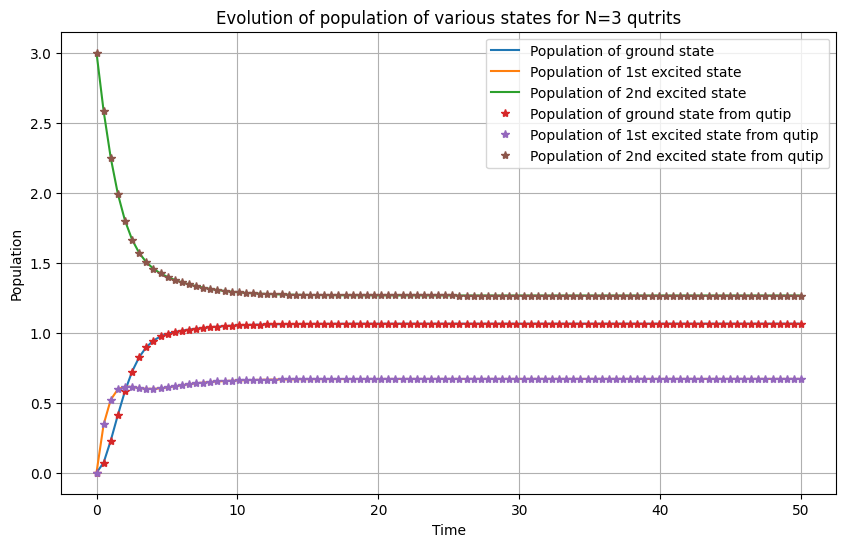

In [8]:
plt.figure(figsize=(10,6))

plt.plot(t_eval, J00, label="Population of ground state")
plt.plot(t_eval, J11, label="Population of 1st excited state")
plt.plot(t_eval, J22, label="Population of 2nd excited state")


plt.plot(t_eval, result.expect[0],"*", label="Population of ground state from qutip")
plt.plot(t_eval, result.expect[1],'*', label="Population of 1st excited state from qutip")
plt.plot(t_eval, result.expect[2],'*', label="Population of 2nd excited state from qutip")

plt.xlabel("Time")
plt.ylabel("Population")
plt.title(r"Evolution of population of various states for N="+str(N)+" qutrits")
plt.grid(True)
plt.legend()
plt.show()